# ResNet NSFW Classification

# Load DataSets

In [1]:
import tensorflow as tf
import hyperopt as hpropt
import numpy as np
import math
import timeit
import random
import pickle
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from util import import_dataset, sample_data, plot_confusion_matrix
from model import Model, lazy_property
from config import ModelConfig, TrainConfig
%matplotlib inline

# Set default to auto import packages
%load_ext autoreload
%autoreload 2

In [2]:
# Form training, developement, and testing data sets
"""
address = r'../../data/smallDataset/'
file_names = {}
file_names['images'] = 'data.npy'
file_names['subs'] = 'subredditlabels'
file_names['dict'] = 'subredditIndex'
file_names['nsfw'] = 'nsfwlabels'
"""
address = r'../../data/fullData/'
file_names = {}
file_names['images'] = 'full_data.npy'
file_names['subs'] = 'full_subredditlabels'
file_names['dict'] = 'full_subredditIndex'
file_names['nsfw'] = 'full_nsfwlabels'

data, dictionary = import_dataset(address, file_names)

# Print the sizes as a sanity check
print('Train data shape: ', data.X_train.shape)
print('Train labels shape: ', data.y_train.shape)
print('Validation data shape: ', data.X_val.shape)
print('Validation labels shape: ', data.y_val.shape)
print('Test data shape: ', data.X_test.shape)
print('Test labels shape: ', data.y_test.shape)

Train data shape:  (25450, 128, 128, 3)
Train labels shape:  (25450,)
Validation data shape:  (3181, 128, 128, 3)
Validation labels shape:  (3181,)
Test data shape:  (3182, 128, 128, 3)
Test labels shape:  (3182,)


In [3]:
# Number of different convolutions
NdistinctConvLayers = 2
# Number of layers for each different convolution
Nlayers = [2, 2, 2, 2]
# Number of filters for each different convolution
Nfilters = [64, 128, 256, 512]
# Size of filters
kernelSizes = [3, 3]

model_config = ModelConfig(learning_rate=0.00175, eval_batch_size=100, output="nsfw")

model_config.RS_NdistinctConvLayers = NdistinctConvLayers
model_config.RS_Nlayers = Nlayers
model_config.RS_Nfilters = Nfilters
model_config.RS_kernelSizes = kernelSizes

In [4]:
class ResNet(Model):
    
    def __init__(self, model_config):
        Model.__init__(self, model_config)
    
    @lazy_property
    def prediction(self):
        
        conv_init = tf.layers.conv2d(
                    inputs = self.X_placeholder,
                    filters = 64,
                    kernel_size = [7, 7],
                    strides = 2,
                    padding = "same")
    
        block_input = tf.layers.max_pooling2d(
                    inputs = conv_init,
                    pool_size = [2, 2],
                    strides = 2)
    
        for idl in range(self.config.RS_NdistinctConvLayers) :
            if (idl == 0) :
                firstStride = 1
            else :
                firstStride = 2
            
            conv = tf.layers.conv2d(
                        inputs = block_input,
                        filters = self.config.RS_Nfilters[idl],
                        kernel_size = self.config.RS_kernelSizes[0],
                        strides = firstStride,
                        padding = "same")
            convBN = tf.layers.batch_normalization(
                        conv, 
                        training=self.is_training_placeholder)        
            relu = tf.nn.relu(convBN)
            residual = tf.layers.conv2d(
                        inputs = relu,
                        filters = self.config.RS_Nfilters[idl],
                        kernel_size = self.config.RS_kernelSizes[1],
                        strides = 1,
                        padding = "same")
            residualBN = tf.layers.batch_normalization(
                        residual, 
                        training=self.is_training_placeholder)
            block_input = tf.nn.relu(residualBN)
        
            for ilr in range(self.config.RS_Nlayers[idl] - 1) :
            
                conv = tf.layers.conv2d(
                            inputs = block_input,
                            filters = self.config.RS_Nfilters[idl],
                            kernel_size = self.config.RS_kernelSizes[0],
                            strides = 1,
                            padding = "same")
                convBN = tf.layers.batch_normalization(
                            conv, 
                            training=self.is_training_placeholder)        
                relu = tf.nn.relu(convBN)
                residual = tf.layers.conv2d(
                            inputs = relu,
                            filters = self.config.RS_Nfilters[idl],
                            kernel_size = self.config.RS_kernelSizes[1],
                            strides = 1,
                            padding = "same")
                residualBN = tf.layers.batch_normalization(
                            residual, 
                            training=self.is_training_placeholder)        
                output = block_input + residualBN
                outputBN = tf.layers.batch_normalization(
                            output, 
                            training=self.is_training_placeholder)
                block_input = tf.nn.relu(outputBN)
            
        convRes = tf.layers.batch_normalization(
                    block_input, 
                    training=self.is_training_placeholder)
    
        shape = convRes.get_shape().as_list()
        avgPool = tf.nn.avg_pool(
                    value=convRes, 
                    ksize=[1,shape[1],shape[2],1],
                    strides=[1,1,1,1],
                    padding='VALID')
    
        shape = avgPool.get_shape().as_list()
        avgPool_flat = tf.reshape(avgPool,[-1, shape[1]*shape[2]*shape[3]])
        logits = tf.layers.dense(inputs=avgPool_flat, units=2)

        return logits

# Train the Model

In [7]:
# Create model instance
tf.reset_default_graph()

train_config = TrainConfig(num_epochs=19, 
                    train_batch_size=64, 
                    print_every=100, 
                    lr_decay = 0.989,
                    saver_address=r'../../parameters/',
                    save_file_name = 'ResNet_nsfw_classification2')
model = ResNet(model_config)

# Create session
session = tf.Session()
model.train(data, session, train_config)

---------------------------------------------------------
Batch 100/398 of epoch 1 finished in 16.044418 seconds
Batch 200/398 of epoch 1 finished in 15.464788 seconds
Batch 300/398 of epoch 1 finished in 15.274275 seconds
Epoch 1 training finished in 61.760591 seconds
train accuracy:92.3%
val accuracy:93.3%
Epoch 1 evaluation finished in 13.091116 seconds
---------------------------------------------------------
Batch 100/398 of epoch 2 finished in 15.421379 seconds
Batch 200/398 of epoch 2 finished in 15.389542 seconds
Batch 300/398 of epoch 2 finished in 15.397347 seconds
Epoch 2 training finished in 61.261259 seconds
train accuracy:81.2%
val accuracy:81.4%
Epoch 2 evaluation finished in 12.831259 seconds
---------------------------------------------------------
Batch 100/398 of epoch 3 finished in 15.341560 seconds
Batch 200/398 of epoch 3 finished in 15.271324 seconds
Batch 300/398 of epoch 3 finished in 15.434854 seconds
Epoch 3 training finished in 61.208753 seconds
train accura

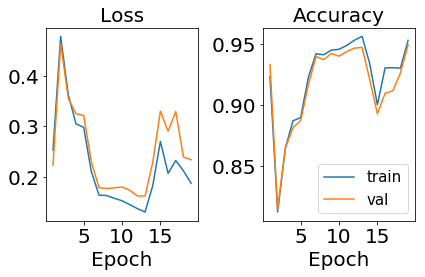

In [8]:
# Plot Loss and Accuracy
model.plot_loss_acc(data, save_address = '../../plots/', save_name = 'nsfw_history', \
    title_font = 20, tick_font = 20, legend_font = 15, axis_font = 20)

# Confusion Matrix

In [9]:
y_val_pred = session.run(model.prediction, {model.X_placeholder: data.X_val, 
                                            model.y_placeholder: data.y_val_2, 
                                            model.is_training_placeholder:False})
y_val_pred = np.argmax(y_val_pred, axis = 1)

Normalized confusion matrix


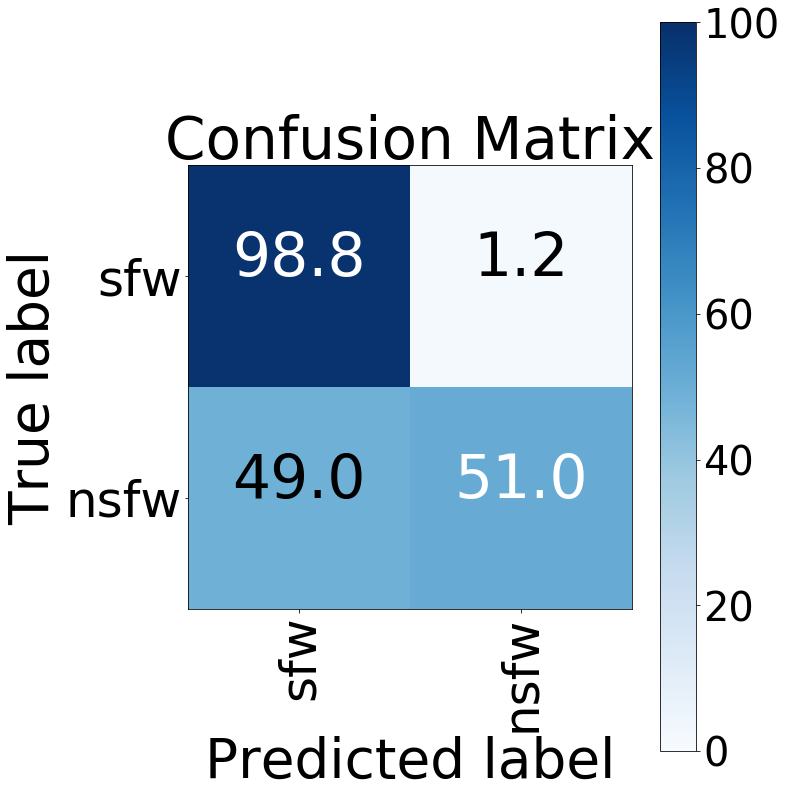

In [10]:
classes = ['sfw', 'nsfw']

conf = confusion_matrix(data.y_val_2, y_val_pred)
plot_confusion_matrix(conf, classes=classes, normalize = True, task = "nsfw",\
    save_address = '../../plots/', save_name = 'nsfw_confusion')

# Evaluate on Test

In [11]:
cost, accuracy = model.eval(data, session, "test")

test accuracy:94.7%


### Confusion Matrix

In [12]:
y_test_pred = session.run(model.prediction, {model.X_placeholder: data.X_test, 
                                            model.y_placeholder: data.y_test_2, 
                                            model.is_training_placeholder:False})
y_test_pred = np.argmax(y_test_pred, axis = 1)

Normalized confusion matrix


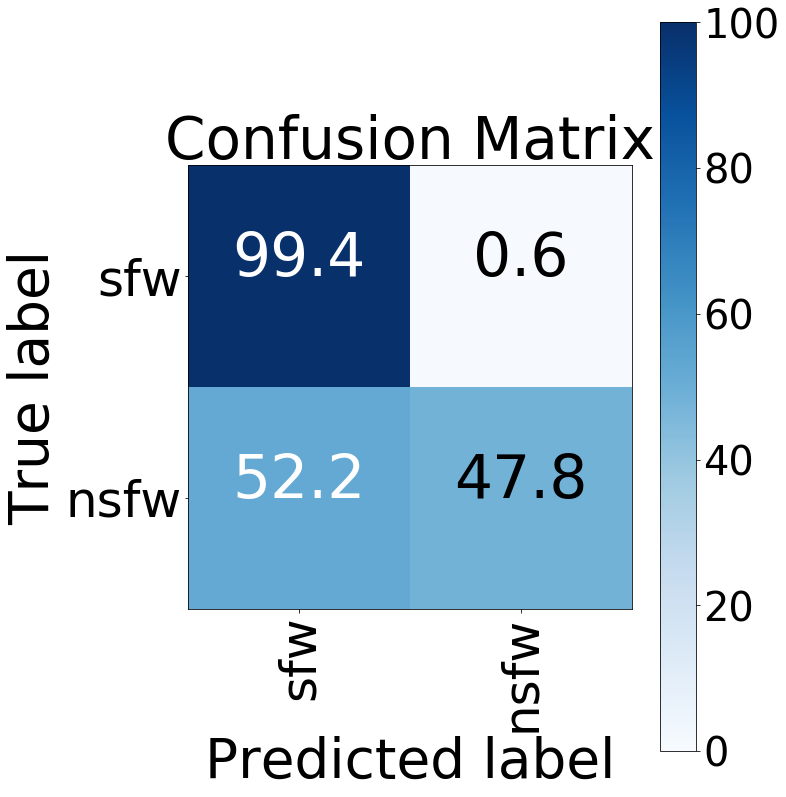

In [13]:
classes = ['sfw', 'nsfw']

conf = confusion_matrix(data.y_test_2, y_test_pred)
plot_confusion_matrix(conf, classes=classes, normalize = True, task = "nsfw",\
    save_address = '../../plots/', save_name = 'test_nsfw_confusion')

# Hyperparameter Search

In [5]:
train_config = TrainConfig(num_epochs=8, 
                    train_batch_size=64, 
                    print_every=1000)
modelHP = ResNet(model_config)
session = tf.Session()

def objective(args):

    tf.reset_default_graph()
    modelHP = ResNet(model_config)
    session = tf.Session()
    
    #train_config.num_epochs = args['Nepochs']
    train_config.lr_decay = args['decayRate']
    modelHP.config.learning_rate = args['learningRate']
    
    modelHP.train(data, session, train_config)
    cost, accuracy = modelHP.eval(data, session, "val")
    
    saveList = {
        'accuracy' : accuracy,
        'cost' : cost,
        #'Nepochs' : args['Nepochs'],
        'learningRate' : args['learningRate'],
        'decayRate' : args['decayRate']
    }    
    pickle.dump(saveList, open("../../hprOpt/nsfw/hprPrmOpt_nsfw_" + str(accuracy) + "_" + str(cost) + ".dat", "wb"))
    
    return cost

def optimize():
    
    space = {
        #'Nepochs' : hpropt.hp.randint('Nepochs', 10),
        'learningRate' : hpropt.hp.loguniform('learningRate', -15, -4),
        'decayRate' : hpropt.hp.uniform('decayRate', 0.9, 1)
    }
    
    best = hpropt.fmin(objective, space, algo=hpropt.tpe.suggest, max_evals=500)
    print(best)
    
    return best

In [6]:
optimize()

---------------------------------------------------------
Epoch 1 training finished in 64.707372 seconds
train accuracy:73.6%
val accuracy:73.5%
Epoch 1 evaluation finished in 13.849769 seconds
---------------------------------------------------------
Epoch 2 training finished in 62.435393 seconds
train accuracy:77.6%
val accuracy:77.5%
Epoch 2 evaluation finished in 13.300302 seconds
---------------------------------------------------------
Epoch 3 training finished in 62.416721 seconds
train accuracy:73.9%
val accuracy:73.4%
Epoch 3 evaluation finished in 13.313330 seconds
---------------------------------------------------------
Epoch 4 training finished in 62.302669 seconds
train accuracy:80.2%
val accuracy:79.6%
Epoch 4 evaluation finished in 13.505154 seconds
---------------------------------------------------------
Epoch 5 training finished in 62.428310 seconds
train accuracy:87.6%
val accuracy:87.3%
Epoch 5 evaluation finished in 13.420753 seconds
------------------------------

KeyboardInterrupt: 